In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
import optuna 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings
from scipy.signal import savgol_filter

%matplotlib inline

In [3]:
np.random.seed(1)
    
   
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [4]:
FILE_WAY = '/kaggle/input/nasa-battery-dataset/cleaned_dataset' 
metadata = pd.read_csv(f'{FILE_WAY}/metadata.csv')
metadata.head()  # Capacity ~ SOH

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN


In [5]:
class Battery:
    """NASA battery data loader and processor."""
    
    def __init__(self, bat_id, to_sort = False, tensor = False, 
                 crop = None, drop_time = False):
        """
        Args:
            bat_id: Battery ID from metadata
            to_sort: Sort capacity values if True
            tensor: Convert to PyTorch tensors if True  
            crop: Crop cycles to this length
            drop_time: Remove Time column if True
        """
        self.tensor = tensor
        self.bat_id = bat_id
        mask = (metadata['battery_id'] == self.bat_id) & (metadata['type'] == 'discharge')
        self.capacity =  metadata.loc[mask].copy()
        self.capacity.loc[:, 'Capacity'] = pd.to_numeric(self.capacity['Capacity']) / 2.0 # init capacity
        if to_sort:
            self.capacity = self.capacity.sort_values('Capacity')
        self.y = np.array(self.capacity['Capacity'], dtype=float)
        if tensor:
            self.y = torch.tensor(self.y, dtype=torch.float32)
        self._get_data(crop=crop, drop_time=drop_time)
        
        
    def _get_data(self, crop=None, drop_time=False):
        self.data = []
        self.table = []
        if crop is None:
            crop = float('inf')
            for file in self.capacity['filename']:
                table = pd.read_csv(f'{FILE_WAY}/data/{file}')
                crop = min(crop, table.shape[0]) # select min shape 
                
        for file in self.capacity['filename']:
            table = pd.read_csv(f'{FILE_WAY}/data/{file}')
            if drop_time:
                table = table.drop(columns=['Time'])

            self.table.append(np.array(table)[:crop])
        self.table = np.array(self.table)
        if self.tensor:
            self.table = torch.tensor(self.table, dtype=torch.float32)
            
    def __str__(self):
        return f"Battery_{int(self.bat_id[-2:])}"
        

def results(y_test: np.ndarray, y_pred: np.ndarray, ax: plt.Axes = None, 
           label: str = '') -> dict:
    """
    Plot and calculate metrics for SOH predictions.
    
    Returns:
        dict with r2, rmse, mae metrics
    """
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f'R2 score = {r2:.3f}')
    print(f'rmse = {100 * rmse:.3f}%')
    print(f'mae = {mae:.3f}')
    if ax is None:
        fig, ax = plt.subplots(figsize=(15,15))
    cycles = np.arange(1, len(y_test) + 1)
    ax.plot(cycles, y_test, color='red', label='Test SOH')
    ax.plot(cycles, y_pred, color='green', label='Predicted SOH')
    ax.set_xlabel('Cycle', fontsize=20)
    ax.set_ylabel('SOH', fontsize=20)
    ax.set_title(label, fontsize=20)
    plt.grid()
    ax.legend(fontsize=15)
    return {'r2': r2, 'rmse': rmse, 'mae': mae}




In [6]:
bat7 = Battery('B0007')
X_test_np = bat7.table
crop = X_test_np.shape[1]
X_test_np = X_test_np.reshape(X_test_np.shape[0], -1)
y_test_np = bat7.y

bat5 = Battery('B0005')
bat6 = Battery('B0006')

X_train_np = np.concatenate([bat5.table, bat6.table], 0)
X_train_np = X_train_np.reshape(X_train_np.shape[0], -1)
y_train_np = np.concatenate([bat5.y, bat6.y], -1)

bat18 = Battery('B0018', crop=crop)

X_val_np = bat18.table
X_val_np = X_val_np.reshape(X_val_np.shape[0], -1)
y_val_np = bat18.y

X_train_np.shape, X_val_np.shape, X_test_np.shape
# y_train_np.shape

((336, 1074), (132, 1074), (168, 1074))

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
pd.read_csv('/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/00001.csv')

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
0,4.246711,0.000252,6.212696,0.0002,0.000,0.000
1,4.246764,-0.001411,6.234019,0.0002,4.262,9.360
2,4.039277,-0.995093,6.250255,1.0000,3.465,23.281
3,4.019506,-0.996731,6.302176,1.0000,3.451,36.406
4,4.004763,-0.992845,6.361645,1.0000,3.438,49.625
...,...,...,...,...,...,...
485,3.303251,-0.001760,9.662331,0.0004,0.000,6382.063
486,3.310303,-0.000756,9.390489,0.0002,0.000,6395.547
487,3.317351,-0.003318,9.137008,0.0002,0.000,6409.063
488,3.323387,-0.002291,8.972806,0.0002,0.000,6422.625


In [9]:
def extract_ica_features(X, min_volt=2.4, max_volt=4.2):
    n_samples = X.shape[0]
    features = []

    for i in range(n_samples):
        voltage = X[i, :, 0]  
        current = X[i, :, 1]  
        time = X[i, :, -1]  



        # filter by cut_off voltage
        mask = (voltage >= min_volt) & (voltage <= max_volt)
        voltage = voltage[mask]
        current = current[mask]
        time = time[mask]
        
        dt = np.diff(time, prepend=time[0]) / 3600  

        Q = np.cumsum(np.abs(current) * dt)

        dQ = np.gradient(Q)
        dV = np.gradient(voltage)
        dQ_dV = dQ / dV

        dQ_dV_smooth = savgol_filter(dQ_dV, window_length=15, polyorder=2)

        peak_height = np.min(dQ_dV_smooth)
        peak_idx = np.argmin(dQ_dV_smooth)
        peak_voltage = voltage[peak_idx]  
        area_under_curve = np.trapz(dQ_dV_smooth, voltage)

        features.append([peak_height, peak_voltage, area_under_curve])
        
    return dQ_dV_smooth, voltage, np.array(features)

min_voltages = {5: 2.7, 6: 2.7, 7: 2.2, 18: 2.5}

dqdv_train, v_tr, ica_train = extract_ica_features(np.concatenate([bat5.table, bat6.table], 0), min_volt=2.7)
dqdv_val, v_val, ica_val = extract_ica_features(bat18.table, min_volt=2.2)
dqdv_test, v_test, ica_test = extract_ica_features(bat7.table, min_volt=2.5)



In [11]:
X_train_ica_np = np.concatenate([X_train_np, ica_train], 1)
X_val_ica_np = np.concatenate([X_val_np, ica_val], 1)
X_test_ica_np = np.concatenate([X_test_np, ica_test], 1)



In [12]:
# try catboost with optuna.
def objective_catboost(trial, X_train, y_train, X_val, y_val):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, log=True),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
        'verbose': False, 
        'random_seed': 1488,
        'loss_function': 'RMSE',  
        'task_type': 'GPU',  
        # uncomment if cuda is available 
    }
   
    
    model = CatBoostRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        verbose=False
    )
    
    y_val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)

    return np.sqrt(mse)

In [9]:
# GBT on flattened data
study_catboost = optuna.create_study(
    direction='minimize'
)

study_catboost.optimize(lambda trial: objective_catboost(trial, X_train_np, 
                                                         y_train_np, X_val_np, y_val_np), 
                        n_trials=30, show_progress_bar=True)



[I 2025-09-23 12:38:00,635] A new study created in memory with name: no-name-8df15461-e613-4925-ac15-f81302812e09


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-23 12:38:38,797] Trial 0 finished with value: 0.017248666501571672 and parameters: {'iterations': 1034, 'learning_rate': 0.007856586896038378, 'depth': 6, 'l2_leaf_reg': 8.829593381482013, 'random_strength': 4.139631057765938, 'bagging_temperature': 0.033124644828591676, 'leaf_estimation_iterations': 1}. Best is trial 0 with value: 0.017248666501571672.
[I 2025-09-23 12:39:16,471] Trial 1 finished with value: 0.02419738274330912 and parameters: {'iterations': 556, 'learning_rate': 0.006218028477714037, 'depth': 6, 'l2_leaf_reg': 2.0725198917457925, 'random_strength': 0.3017930892177149, 'bagging_temperature': 0.5931634958121119, 'leaf_estimation_iterations': 12}. Best is trial 0 with value: 0.017248666501571672.
[I 2025-09-23 12:39:28,210] Trial 2 finished with value: 0.028875272269674512 and parameters: {'iterations': 1806, 'learning_rate': 0.014153587146431734, 'depth': 5, 'l2_leaf_reg': 3.963823815228739, 'random_strength': 0.5443174620294428, 'bagging_temperature': 0.894

In [10]:
study_catboost.best_params

{'iterations': 903,
 'learning_rate': 0.06418816172608086,
 'depth': 9,
 'l2_leaf_reg': 6.142064724242676,
 'random_strength': 8.614487778853867,
 'bagging_temperature': 0.3724819764710204,
 'leaf_estimation_iterations': 4}

In [11]:
best_cat_model = CatBoostRegressor(**study_catboost.best_params)
best_cat_model.fit(
    X_train_np, y_train_np,
    eval_set=(X_val_np, y_val_np),
    early_stopping_rounds=50,
    verbose=False
)

R2 score = 0.817812
rmse = 3.424725%
mae = 0.028004


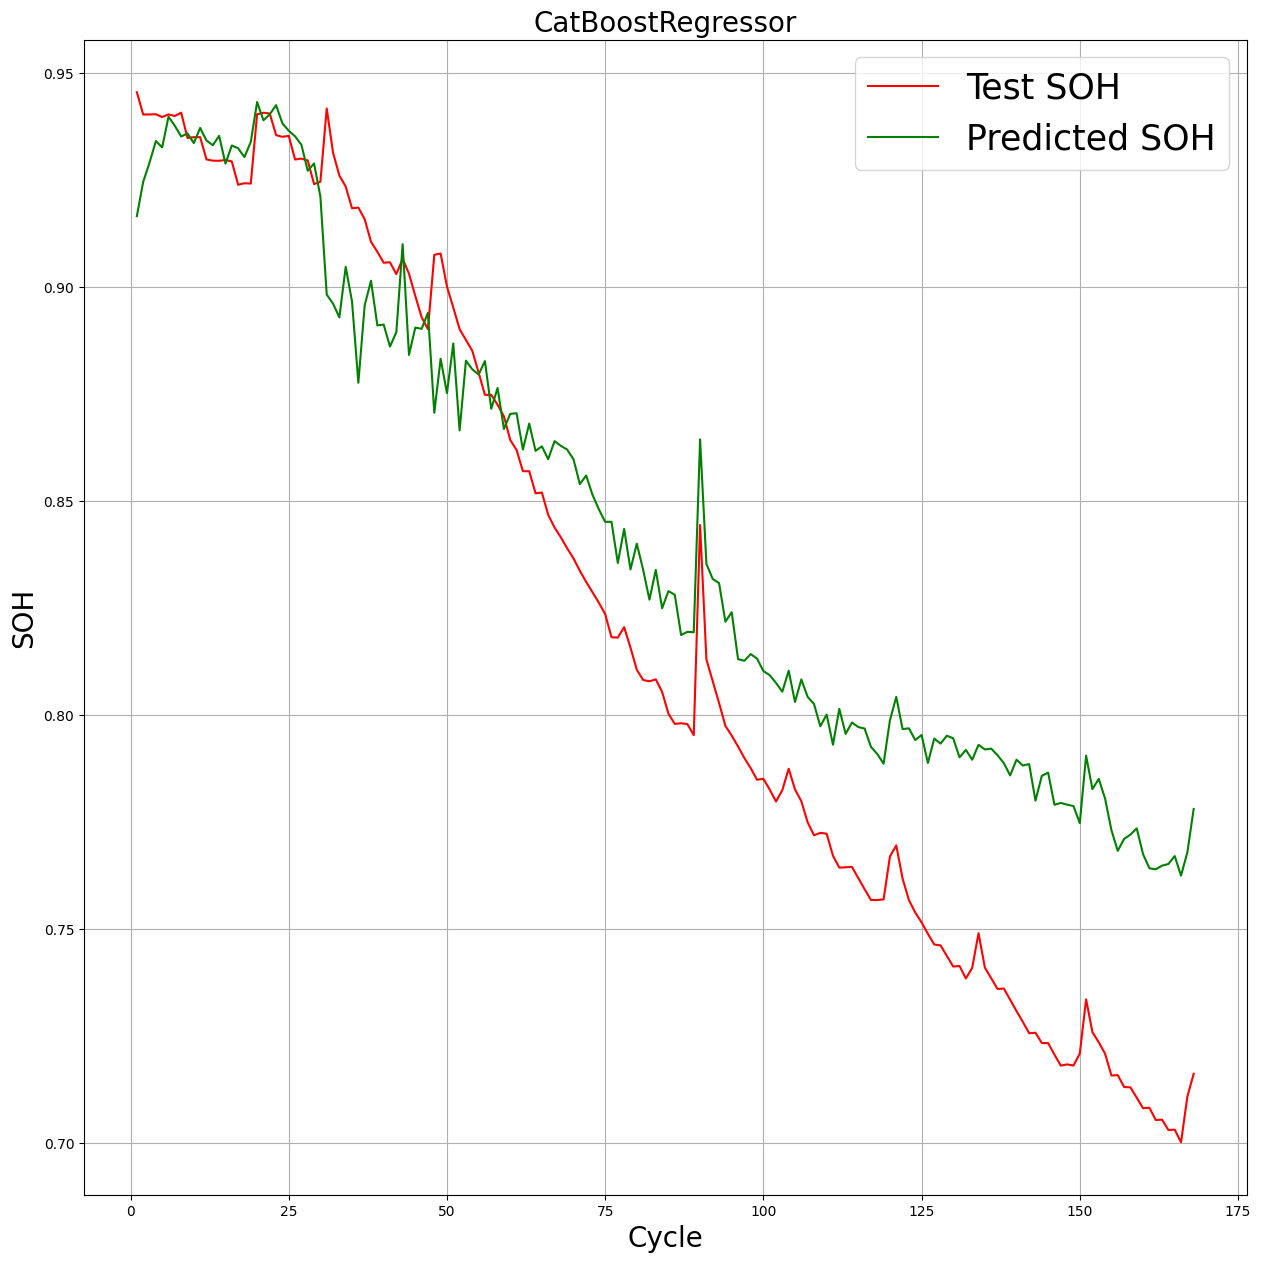

In [19]:
# GBT results on flattened data
y_cat_pred = best_cat_model.predict(X_test_np)
results(y_test_np, y_cat_pred, label='CatBoostRegressor')

In [125]:
# GBT on only ica data
study_catboost_ica = optuna.create_study(
    direction='minimize'
)

study_catboost_ica.optimize(lambda trial: objective_catboost(trial, ica_train, 
                                                         y_train_np, ica_val, y_val_np), 
                        n_trials=30, show_progress_bar=True)


[I 2025-09-24 12:20:02,343] A new study created in memory with name: no-name-473cc337-375c-4627-858e-625964148ec6


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-24 12:20:05,642] Trial 0 finished with value: 0.05987533636060846 and parameters: {'iterations': 1932, 'learning_rate': 0.00810820328104699, 'depth': 5, 'l2_leaf_reg': 2.770541572547937, 'random_strength': 7.11111715531233, 'bagging_temperature': 0.08849138964014125, 'leaf_estimation_iterations': 12}. Best is trial 0 with value: 0.05987533636060846.
[I 2025-09-24 12:20:10,939] Trial 1 finished with value: 0.047656775518587914 and parameters: {'iterations': 1874, 'learning_rate': 0.024868192058077748, 'depth': 5, 'l2_leaf_reg': 1.4225551062485404, 'random_strength': 0.4452524933843514, 'bagging_temperature': 0.2906011944038207, 'leaf_estimation_iterations': 12}. Best is trial 1 with value: 0.047656775518587914.
[I 2025-09-24 12:20:13,698] Trial 2 finished with value: 0.040644082422006185 and parameters: {'iterations': 1460, 'learning_rate': 0.0926680486239797, 'depth': 5, 'l2_leaf_reg': 3.903585978159436, 'random_strength': 3.786764236427111, 'bagging_temperature': 0.77038051

{'iterations': 1610, 'learning_rate': 0.012188108835493752, 'depth': 10, 'l2_leaf_reg': 9.380022875610399, 'random_strength': 0.22052471067479593, 'bagging_temperature': 0.9382883428948494, 'leaf_estimation_iterations': 1}
R2 score = 0.879157
rmse = 2.789178%
mae = 0.024803


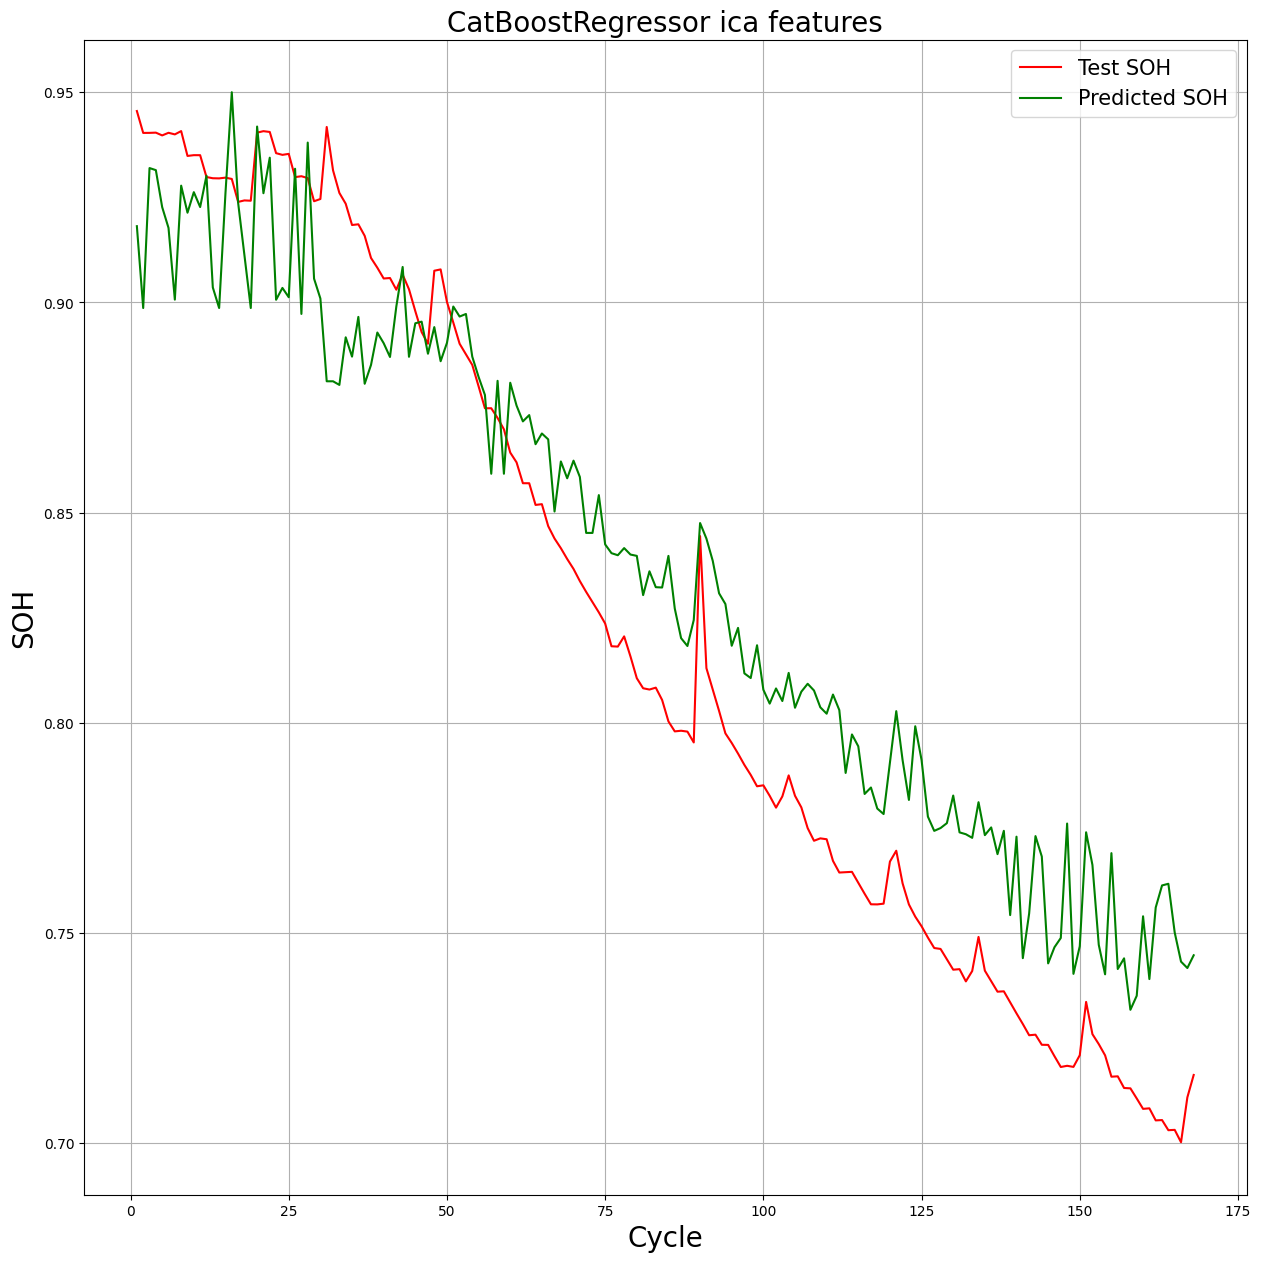

In [126]:
print(study_catboost_ica.best_params)
best_cat_model_ica = CatBoostRegressor(**study_catboost_ica.best_params)
best_cat_model_ica.fit(
    ica_train, y_train_np,
    eval_set=(ica_val, y_val_np),
    early_stopping_rounds=50,
    verbose=False
)

y_cat_pred = best_cat_model_ica.predict(ica_test)
results(y_test_np, y_cat_pred, label='CatBoostRegressor ica features')

In [90]:
# GBT usage on flattened data + ica data
study_catboost_ica = optuna.create_study(
    direction='minimize'
)

study_catboost_ica.optimize(lambda trial: objective_catboost(trial, X_train_ica_np, 
                                                         y_train_np, X_val_ica_np, y_val_np), 
                        n_trials=10, show_progress_bar=True)


[I 2025-09-24 11:13:52,050] A new study created in memory with name: no-name-3caac29c-74d0-4b0e-a438-0166c6258abf


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-09-24 11:14:23,805] Trial 0 finished with value: 0.01575317035421102 and parameters: {'iterations': 600, 'learning_rate': 0.040657821623720926, 'depth': 8, 'l2_leaf_reg': 3.5744740640123096, 'random_strength': 1.68810883902839, 'bagging_temperature': 0.36644767513138565, 'leaf_estimation_iterations': 6}. Best is trial 0 with value: 0.01575317035421102.
[I 2025-09-24 11:14:46,678] Trial 1 finished with value: 0.019898898581918317 and parameters: {'iterations': 884, 'learning_rate': 0.007622336001498973, 'depth': 5, 'l2_leaf_reg': 2.6389375568554487, 'random_strength': 0.3655354089352611, 'bagging_temperature': 0.180268795271869, 'leaf_estimation_iterations': 15}. Best is trial 0 with value: 0.01575317035421102.
[I 2025-09-24 11:15:17,354] Trial 2 finished with value: 0.016652240266131334 and parameters: {'iterations': 1526, 'learning_rate': 0.016606912213995795, 'depth': 7, 'l2_leaf_reg': 1.6350293737177686, 'random_strength': 0.17107906981215695, 'bagging_temperature': 0.895651

{'iterations': 600, 'learning_rate': 0.040657821623720926, 'depth': 8, 'l2_leaf_reg': 3.5744740640123096, 'random_strength': 1.68810883902839, 'bagging_temperature': 0.36644767513138565, 'leaf_estimation_iterations': 6}
R2 score = 0.756419
rmse = 3.959926%
mae = 0.035335


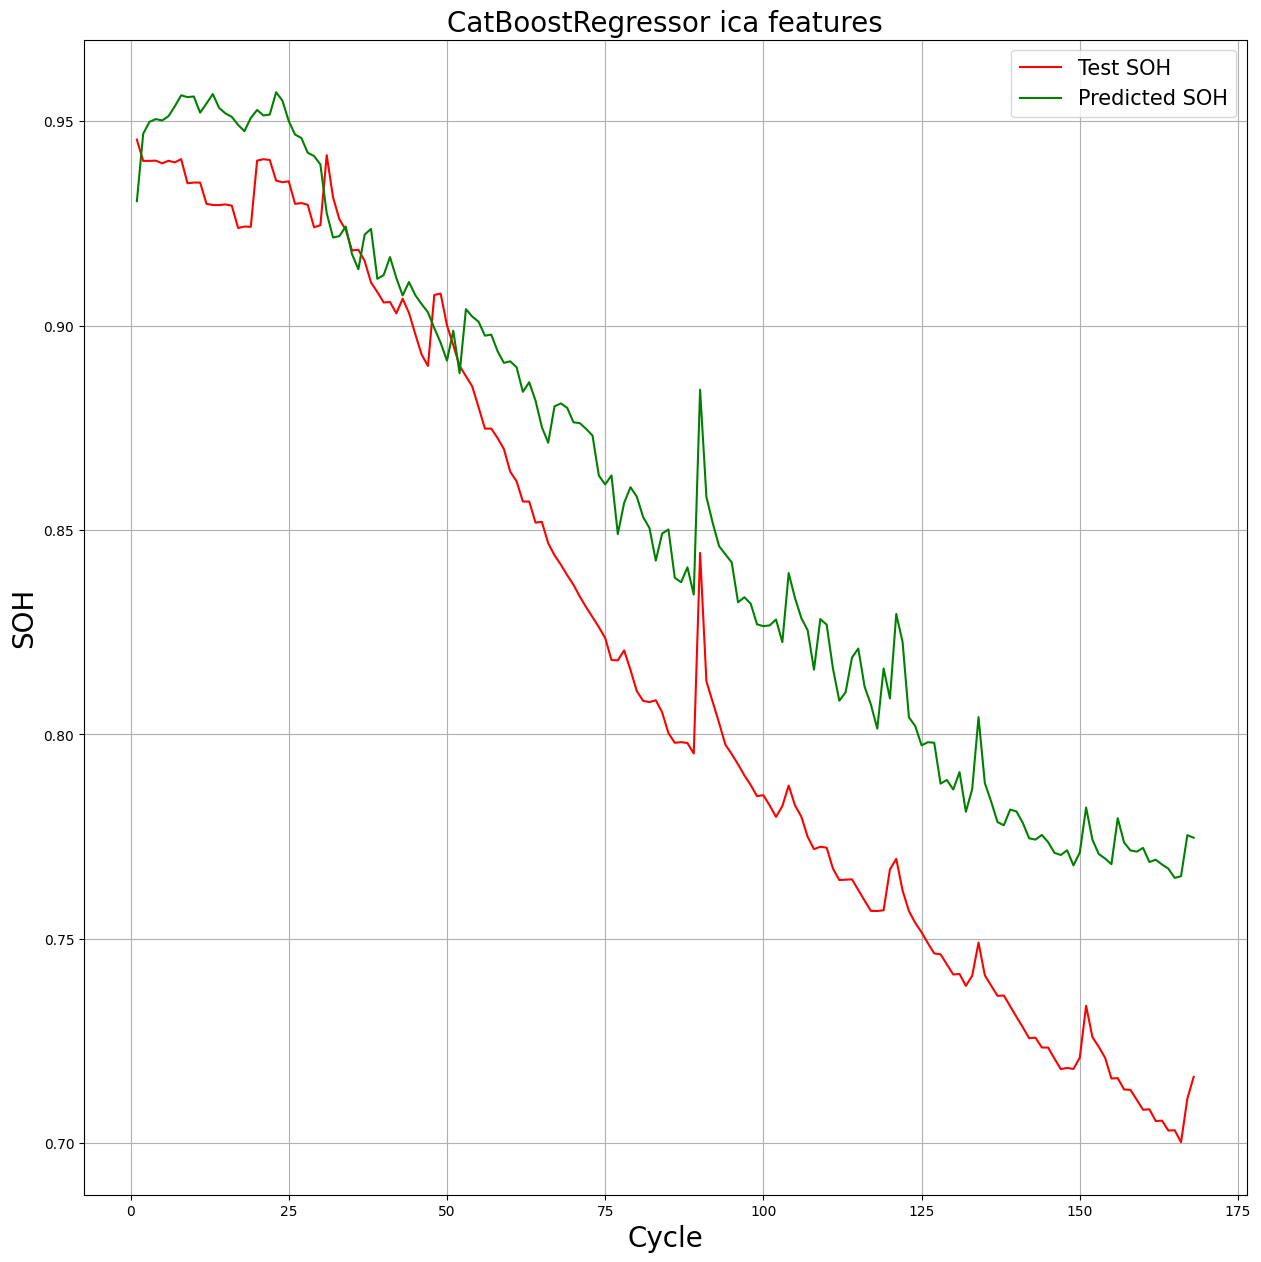

In [96]:
print(study_catboost_ica.best_params)
best_cat_model_ica = CatBoostRegressor(**study_catboost_ica.best_params)
best_cat_model_ica.fit(
    X_train_ica_np, y_train_np,
    eval_set=(X_val_ica_np, y_val_np),
    early_stopping_rounds=50,
    verbose=False
)

y_cat_pred = best_cat_model_ica.predict(X_test_ica_np)
results(y_test_np, y_cat_pred, label='CatBoostRegressor ica features')